# 케글 산탄데르 고객만족(Santandel Customer Satisfaction) 데이터 세트

### 케글 산탄데르 고객 만족 예측 대회

* 대회 개요
https://www.kaggle.com/c/santander-customer-satisfaction

- 불만고객(1) 분류하기
성능평가: ROC-AUC ( 대부분이 만족이고 불만족인 데이터는 소수인 불균형 데이터세트)

- 데이터셋 다운로드: 
https://www.kaggle.com/c/santander-customer-satisfaction/data

- 다운로드 후 데이터셋 이름 변경
train.csv -> train_santander.csv
test.csv -> test_santander.csv 

- XGBoost, LightGBM으로 예측

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('data/santander-customer-satisfaction/train.csv', encoding='latin-1')

### 데이터 전처리

In [3]:
cust_df.isnull().sum().sum()

0

In [4]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


*  레이블 (Target) 의 분포 확인(불만족 고객 비율)

In [5]:
cust_df.TARGET.value_counts(normalize=True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

In [6]:
cust_df.describe() # 예전에 데이터가 디지털로 변환되기 전에, null 값을 -999999라고 기록한 것으로 보인다.

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
# var3 피처 값 대체 및 ID 피처 드롭

cust_df.var3.value_counts() # 그 값을 어떻게 처리할지 생각해봐야 한다.

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [8]:
# 지금은 var3 열에 2가 제일 많이 존재하므로
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

In [9]:
# 피처 세트(특성 데이터)와 레이블(TARGET) 세트분리. 
X = cust_df.iloc[:, :-1]
y = cust_df.iloc[:, -1]

X.shape, y.shape

((76020, 369), (76020,))

In [10]:
# train, test set 분리: test_size=0.2, random_state=0
# 불균형 데이터이므로 학습세트와 테스트세트에 레이블 분포가 유사한지 확인
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [11]:
y_train.value_counts(normalize=True)

0    0.960438
1    0.039562
Name: TARGET, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.960405
1    0.039595
Name: TARGET, dtype: float64

## 1. XGBoost 모델 

### XGBoost 모델 학습

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

XGBClassifier?

Init signature:
XGBClassifier(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
    use_label_encoder: Optional[bool] = None,
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.


Parameters
----------

    n_estimators : int
        Number of boosting rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid values are 

In [14]:
?XGBClassifier.fit

Signature:
XGBClassifier.fit(
    self,
    X: Any,
    y: Any,
    *,
    sample_weight: Optional[Any] = None,
    base_margin: Optional[Any] = None,
    eval_set: Optional[Sequence[Tuple[Any, Any]]] = None,
    eval_metric: Union[str, Sequence[str], Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]], NoneType] = None,
    early_stopping_rounds: Optional[int] = None,
    verbose: Union[bool, int, NoneType] = True,
    xgb_model: Union[xgboost.core.Booster, str, xgboost.sklearn.XGBModel, NoneType] = None,
    sample_weight_eval_set: Optional[Sequence[Any]] = None,
    base_margin_eval_set: Optional[Sequence[Any]] = None,
    feature_weights: Optional[Any] = None,
    callbacks: Optional[Sequence[xgboost.callback.TrainingCallback]] = None,
) -> 'XGBClassifier'
Docstring:
Fit gradient boosting classifier.

Note that calling ``fit()`` multiple times will cause the model object to be
re-fit from scratch. To resume training from a previous checkpoint, explicitly
pass ``xgb_m

In [15]:
# n_estimators=500, random state=156
xgb = XGBClassifier(n_estimators=500, random_state=156, use_label_encoder=False)

In [16]:
# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 

xgb.fit(X_train, y_train, early_stopping_rounds=100,
eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], 
verbose=True) # 1에 가깝게 auc 값이 변화하며 성능이 개선되는 것이 확인된다

[0]	validation_0-auc:0.82570	validation_1-auc:0.79283
[1]	validation_0-auc:0.84010	validation_1-auc:0.80737
[2]	validation_0-auc:0.84361	validation_1-auc:0.81021
[3]	validation_0-auc:0.84783	validation_1-auc:0.81287
[4]	validation_0-auc:0.85123	validation_1-auc:0.81469
[5]	validation_0-auc:0.85518	validation_1-auc:0.81860
[6]	validation_0-auc:0.85922	validation_1-auc:0.81977
[7]	validation_0-auc:0.86238	validation_1-auc:0.82034
[8]	validation_0-auc:0.86570	validation_1-auc:0.82147
[9]	validation_0-auc:0.86798	validation_1-auc:0.82301
[10]	validation_0-auc:0.87104	validation_1-auc:0.82379
[11]	validation_0-auc:0.87448	validation_1-auc:0.82456
[12]	validation_0-auc:0.87687	validation_1-auc:0.82401
[13]	validation_0-auc:0.87918	validation_1-auc:0.82467
[14]	validation_0-auc:0.88081	validation_1-auc:0.82508
[15]	validation_0-auc:0.88331	validation_1-auc:0.82379
[16]	validation_0-auc:0.88569	validation_1-auc:0.82457
[17]	validation_0-auc:0.88674	validation_1-auc:0.82453
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=156, ...)

In [18]:
xgb.best_score

0.8250790293597428

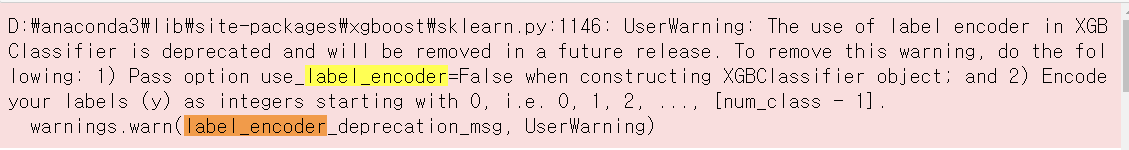

In [ ]:
# warning 제거를 위해 y_train, y_test 자료구조를 numpy로 바꿔줌

In [17]:
xgb?

Type:        XGBClassifier
String form:
XGBClassifier(base_score=None, booster=None, callbacks=None,
           colsample_bylevel=None <...> rs=500, n_jobs=None, num_parallel_tree=None,
           predictor=None, random_state=156, ...)
File:        c:\users\playdata\anaconda3\lib\site-packages\xgboost\sklearn.py
Docstring:  
Implementation of the scikit-learn API for XGBoost classification.


Parameters
----------

    n_estimators : int
        Number of boosting rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Op

#### 첫 번째 하이퍼파라미터 튜닝 (0.8404 -> ?? )

In [20]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
params = {
    'max_depth' : [3, 5, 7],
    'min_child_weight' : [1, 3],
    'colsample_bytree' : [0.5, 0.75]
}
# cv는 3으로 지정 
grid = GridSearchCV(xgb, param_grid=params, cv=3)
grid.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-auc:0.78167	validation_1-auc:0.75531
[1]	validation_0-auc:0.80981	validation_1-auc:0.78496
[2]	validation_0-auc:0.81047	validation_1-auc:0.78302
[3]	validation_0-auc:0.81286	validation_1-auc:0.78341
[4]	validation_0-auc:0.81822	validation_1-auc:0.79186
[5]	validation_0-auc:0.82404	validation_1-auc:0.79802
[6]	validation_0-auc:0.81893	validation_1-auc:0.79352
[7]	validation_0-auc:0.83380	validation_1-auc:0.80727
[8]	validation_0-auc:0.83636	validation_1-auc:0.81062
[9]	validation_0-auc:0.83650	validation_1-auc:0.80634
[10]	validation_0-auc:0.83672	validation_1-auc:0.80491
[11]	validation_0-auc:0.83582	validation_1-auc:0.80253
[12]	validation_0-auc:0.84102	validation_1-auc:0.80882
[13]	validation_0-auc:0.84272	validation_1-auc:0.81227
[14]	validation_0-auc:0.84514	validation_1-auc:0.81422
[15]	validation_0-auc:0.84634	validation_1-auc:0.81429
[16]	validation_0-auc:0.84793	validation_1-auc:0.81640
[17]	validation_0-auc:0.84822	validation_1-auc:0.81762
[18]	validation_0-au

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3]})

In [21]:
grid.best_score_

0.9605202578268877

In [22]:
grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
grid.best_params_

{'colsample_bytree': 0.75, 'max_depth': 3, 'min_child_weight': 1}

In [27]:
roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1])

0.8238791413909987

#### 두번째 하이퍼파라미터 튜닝

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 


*  특성 중요도시각화

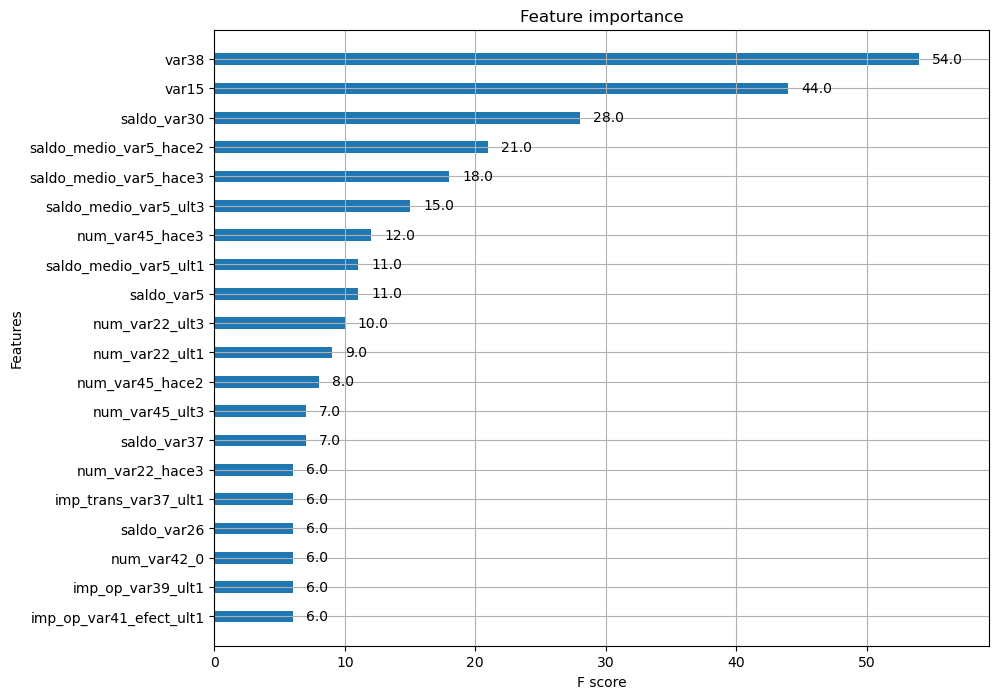

In [28]:
from xgboost import plot_importance

xgb = grid.best_estimator_
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb, ax=ax, max_num_features=20, height=0.4);

## 2.  LightGBM 모델 

In [ ]:
?LGBMClassifier.fit

####  첫번째 하이퍼 파라미터 튜닝(0.8409 -> ? 0.8417)

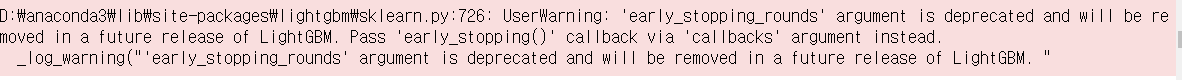

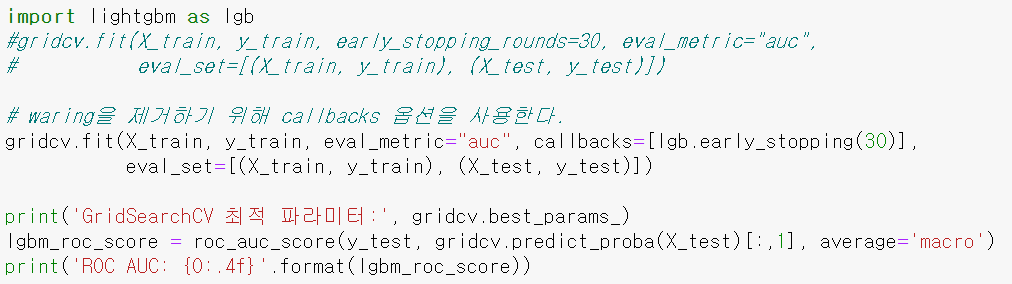

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import lgb

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
        'max_depth':[128, 160],
        'min_child_samples':[60, 100],
        'subsample':[0.8, 1]}

# cv는 3으로 지정 
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)